<a href="https://colab.research.google.com/github/Borboleta-Vermelha/Pokemons/blob/main/Rede_Neural_Pokemon_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iᴍᴘᴏʀᴛᴀᴄ̧ᴏ̃ᴇs

In [ ]:
pip install opendatasets

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__
import pandas as pd
import opendatasets as od
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
from sklearn import preprocessing

In [ ]:
od.download('https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types')

Dataset URL: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types


100%|██████████| 3.68M/3.68M [00:00<00:00, 128MB/s]

In [ ]:
torch.manual_seed(123)

# Bᴀsᴇ ᴅᴇ ᴅᴀᴅᴏs

In [ ]:
transform = transforms.ToTensor()

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
tipos = pd.read_csv('/content/pokemon-images-and-types/pokemon.csv')

In [ ]:
rotulos = {}
for c in range(0, len(tipos)):
  rotulos[list(tipos.Name)[c]] = list(tipos.Type1)[c]
rotulos = dict(sorted(rotulos.items()))

In [ ]:
trans = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

In [ ]:
imagens = datasets.ImageFolder('/content/pokemon-images-and-types/', transform=trans)

In [ ]:
np.unique(list(rotulos.values()))
encoder = LabelEncoder()
rotulos = encoder.fit_transform(list(rotulos.values()))
print(np.unique(rotulos))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [ ]:
a = 0
for n in imagens.samples:
  imagens.samples[a] = (imagens.samples[a][0], rotulos[a])
  a+=1

In [ ]:
import plotly.express as px

In [ ]:
fig = px.histogram(tipos, x='Type1', color_discrete_sequence=['red'])

fig.update_layout(
    width=800, height=400,
    xaxis_title='Tipo',
    yaxis_title='Quantidade',
    font=dict(family='Courier New, monospace',  size=14, color='white'),
    plot_bgcolor='#070A0D',
    paper_bgcolor='#070A0D',
    xaxis=dict( showgrid=False,  color='white'),
    yaxis=dict( showgrid=False, color='white'))

# Mostrando o gráfico
fig.show()

In [ ]:
img_treinamento, img_teste = train_test_split(imagens, test_size=0.10, shuffle=True)
train_loader = torch.utils.data.DataLoader(img_treinamento, batch_size=126, shuffle=True)
img_testes = torch.utils.data.DataLoader(img_teste)

In [ ]:
imagem, rotulo = imagens[551]
imagem = np.transpose(imagem, (1, 2, 0))

fig = px.imshow(imagem)
fig.update_layout(
    width=400, height=400,
    title=f"Rótulo: {rotulo}",
    font=dict(family='Courier New, monospace',  size=14, color='white'),
    coloraxis_showscale=False,
    plot_bgcolor='#070A0D',
    paper_bgcolor='#070A0D',  )

fig.show()

# Cᴏɴsᴛʀᴜᴄ̧ᴀ̃ᴏ ᴅᴏ Mᴏᴅᴇʟᴏ

In [ ]:
class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(in_features=6272, out_features=126)
    self.linear2 = nn.Linear(126, 126)
    self.output = nn.Linear(126, 18)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X

In [ ]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Tʀᴇɪɴᴀᴍᴇɴᴛᴏ

In [ ]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs, labels

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))
        running_accuracy += accuracy

        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss,
                                   accuracy), end = '\r')

    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch+1, running_loss/len(loader),
                     running_accuracy/len(loader)))

In [ ]:
for epoch in range(50):
  print('Treinando...')
  training_loop(train_loader, epoch)
  net.eval()
  print('Validando...')
  training_loop(img_testes, epoch)
  net.train()

Treinando...


<ipython-input-35-73e3beb73df5>:17: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



ÉPOCA   1 FINALIZADA: perda 2.80120 - precisão 0.11565
Validando...
ÉPOCA   1 FINALIZADA: perda 2.81195 - precisão 0.09877
Treinando...
ÉPOCA   2 FINALIZADA: perda 2.82844 - precisão 0.16459
Validando...
ÉPOCA   2 FINALIZADA: perda 2.84330 - precisão 0.13580
Treinando...
ÉPOCA   3 FINALIZADA: perda 2.66547 - precisão 0.21145
Validando...
ÉPOCA   3 FINALIZADA: perda 2.78912 - precisão 0.13580
Treinando...
ÉPOCA   4 FINALIZADA: perda 2.64914 - precisão 0.19766
Validando...
ÉPOCA   4 FINALIZADA: perda 2.76987 - precisão 0.17284
Treinando...
ÉPOCA   5 FINALIZADA: perda 2.40486 - precisão 0.27759
Validando...
ÉPOCA   5 FINALIZADA: perda 2.73822 - precisão 0.16049
Treinando...
ÉPOCA   6 FINALIZADA: perda 2.41716 - precisão 0.24924
Validando...
ÉPOCA   6 FINALIZADA: perda 2.69507 - precisão 0.13580
Treinando...
ÉPOCA   7 FINALIZADA: perda 2.42220 - precisão 0.26134
Validando...
ÉPOCA   7 FINALIZADA: perda 2.63926 - precisão 0.16049
Treinando...
ÉPOCA   8 FINALIZADA: perda 2.43612 - precisão 0

# Aᴠᴀʟɪᴀᴄ̧ᴀ̃ᴏ

In [ ]:
resultados_IA = []
resultados_reais = []

for imagem, rotulo in img_teste:
    imagem_tensor = imagem.view(1, 3, 64, 64)
    output = net.forward(imagem_tensor)
    previsao = F.softmax(output, dim=1)
    previsao = previsao.cpu().detach().numpy()
    resultado = np.argmax(previsao)
    resultados_IA.append(resultado)
    resultados_reais.append(rotulo)

    img_array = np.transpose(imagem.numpy(), (1, 2, 0))
    img_array = (img_array * 255).astype(np.uint8)

    fig = px.imshow(img_array)
    fig.update_layout(
        width=400, height=400,
        title=f'Rótulo: {rotulo}',
        font=dict(family='Courier New, monospace',  size=14, color='white'),
        coloraxis_showscale=False,
        plot_bgcolor='#070A0D', paper_bgcolor='#070A0D',
        annotations=[dict(x=0.5, y=-0.1, xref='paper', yref='paper', text=f'IA: {resultado}',
                showarrow=False,
                font=dict(size=16))])
    fig.show()

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z=matriz,
    colorscale='hot',
    showscale=True,
    text=[[str(val) for val in row] for row in matriz],
    texttemplate="%{text}",
    textfont={"size": 12}
))
fig.update_layout(
    font=dict(family='Courier New, monospace',  size=14, color='white'),
    plot_bgcolor='#070A0D', paper_bgcolor='#070A0D')

fig.show()

In [ ]:
precisao = accuracy_score(resultados_reais, resultados_IA)

In [ ]:
precisao

0.16049382716049382

In [ ]:
classes = np.unique(rotulos)

In [ ]:
contagem_real = np.bincount(resultados_reais, minlength=18)
contagem_predita = np.bincount(resultados_IA, minlength=18)


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(x=classes, y=contagem_real,
    name='Real', marker_color='#592751', opacity=0.7, offsetgroup=0))

fig.add_trace(go.Bar(x=classes, y=contagem_predita,
    name='Previsto', marker_color='#DB1100', opacity=0.7, offsetgroup=1))

fig.update_layout(
    barmode='group', xaxis_title='Classe', yaxis_title='Contagem',
    font=dict(family='Courier New, monospace',  size=14, color='white'),
    title='Resultados Reais vs. Previstos por Classe',
    plot_bgcolor='#070A0D', paper_bgcolor='#070A0D',
    legend=dict(title='Legenda'))

fig.show()

# Vᴀʟɪᴅᴀᴄ̧ᴀ̃ᴏ Cʀᴜᴢᴀᴅᴀ

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

In [ ]:
def evaluation_loop(loader, model, criterion):
    resultados_IA = []
    resultados_reais = []

    for imagem, rotulo in loader:
        imagem_tensor = imagem.view(1, 3, 64, 64)
        output = model.forward(imagem_tensor)
        previsao = F.softmax(output, dim=1)
        previsao = previsao.cpu().detach().numpy()
        resultado = np.argmax(previsao)
        resultados_IA.append(resultado)
        resultados_reais.append(rotulo)

    matriz = confusion_matrix(resultados_IA, resultados_reais)
    sns.heatmap(matriz,annot=True)
    plt.show()
    precisao = accuracy_score(resultados_reais, resultados_IA)
    print(f'Tivemos um acerto de {precisao}')

In [ ]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs, labels

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy


Split 1/5


<ipython-input-60-bb3e687b802b>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Avaliando...


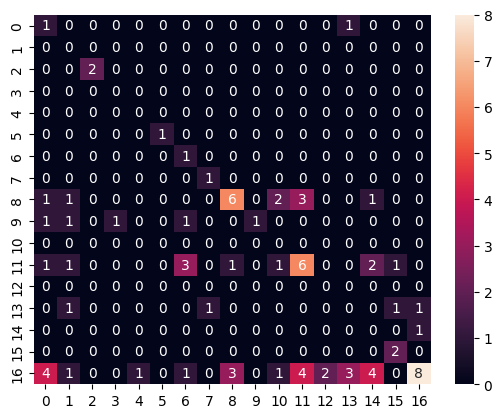

Tivemos um acerto de 0.35802469135802467
Split 2/5


<ipython-input-60-bb3e687b802b>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Avaliando...


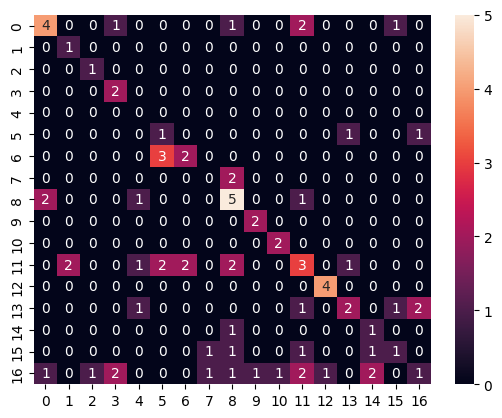

Tivemos um acerto de 0.3950617283950617
Split 3/5


<ipython-input-60-bb3e687b802b>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Avaliando...


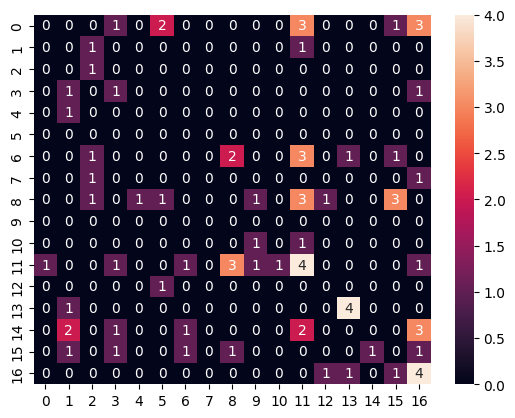

Tivemos um acerto de 0.1728395061728395
Split 4/5


<ipython-input-60-bb3e687b802b>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Avaliando...


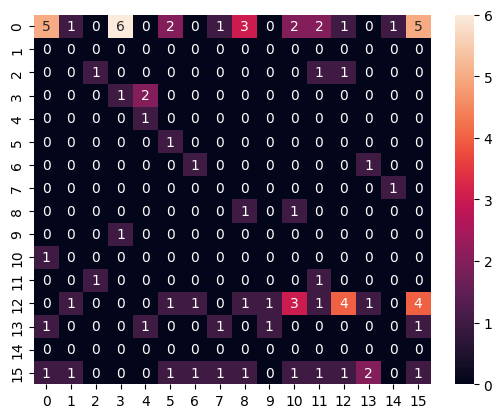

Tivemos um acerto de 0.20987654320987653
Split 5/5


<ipython-input-60-bb3e687b802b>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Avaliando...


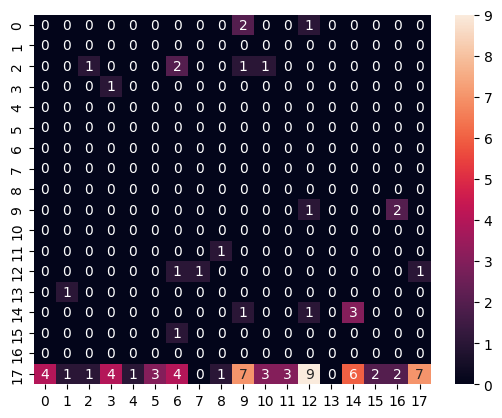

Tivemos um acerto de 0.14814814814814814


In [ ]:
num_epochs = 50
n_splits = 5

fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

for split in range(n_splits):
    torch.manual_seed(123)
    print(f'Split {split+1}/{n_splits}')

    train_ids, test_ids = train_test_split(imagens, test_size=0.10, shuffle=True)
    train_loader = DataLoader(train_ids, batch_size=126, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ids)

    net = classificador()
    optimizer = optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()

    # Treinando o modelo
    for epoch in range(num_epochs):
      training_loop(train_loader, epoch)
      net.eval()
      training_loop(test_loader, epoch)
      net.train()

    # Avaliando o modelo
    print('Avaliando...')
    evaluation_loop(test_loader, net, criterion)

In [ ]:
# Calculando a média dos resultados de todos os folds
mean_train_loss = np.mean(fold_train_losses)
mean_train_accuracy = np.mean(fold_train_accuracies)
mean_test_loss = np.mean(fold_test_losses)
mean_test_accuracy = np.mean(fold_test_accuracies)

print(f'Média de Treinamento - Perda: {mean_train_loss:.4f}, Precisão: {mean_train_accuracy:.4f}')
print(f'Média de Teste - Perda: {mean_test_loss:.4f}, Precisão: {mean_test_accuracy:.4f}')

Média de Treinamento - Perda: nan, Precisão: nan
Média de Teste - Perda: nan, Precisão: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

